In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from importlib import resources

from heagan.tools.functions import pymatgen_comp, data_generator

from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType

import onnxruntime

/Users/adam/opt/anaconda3/envs/cGAN/lib/python3.10/site-packages/skl2onnx/algebra/onnx_ops.py:159: UserWarning: OpSchema.FormalParameter.typeStr is deprecated and will be removed in 1.16. Use OpSchema.FormalParameter.type_str instead.
  tys = obj.typeStr or ''
/Users/adam/opt/anaconda3/envs/cGAN/lib/python3.10/site-packages/skl2onnx/algebra/automation.py:154: UserWarning: OpSchema.FormalParameter.isHomogeneous is deprecated and will be removed in 1.16. Use OpSchema.FormalParameter.is_homogeneous instead.
  if getattr(obj, 'isHomogeneous', False):
/Users/adam/opt/anaconda3/envs/cGAN/lib/python3.10/site-packages/jinja2/environment.py:485: UserWarning: OpSchema.FormalParameter.typeStr is deprecated and will be removed in 1.16. Use OpSchema.FormalParameter.type_str instead.
  return getattr(obj, attribute)


In [2]:
with resources.files('heagan.dataset').joinpath('demo_dataset_true.csv') as fname:
    demo_df = pd.read_csv(fname,index_col = 0)
    demo_df

In [3]:
pmg_comps = pymatgen_comp(demo_df['Composition'].values)
dset = data_generator(pmg_comps, use_all_eles=False)
props_list = list(demo_df.columns[1:])
X = dset.real_data

RMSE:
delta_S  : 0.003929
d_param  : 0.002217
price    : 0.000684
FT       : 0.002382
density  : 0.001686
hardness : 0.042055
uts1200C : 0.000947


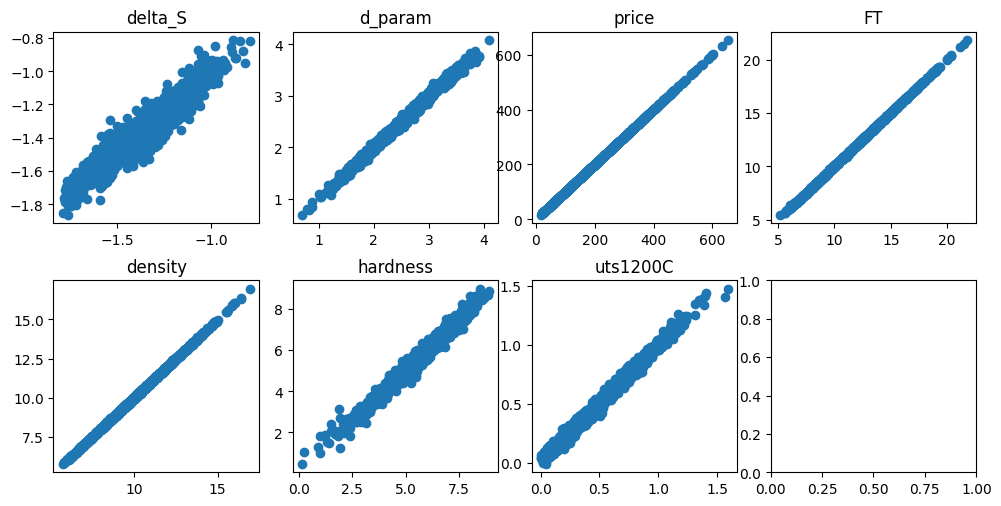

In [4]:
fig,ax = plt.subplots(2,4,figsize = (10,5))
fig.tight_layout(h_pad=2.0, w_pad=-1)
ax = ax.ravel()
print('RMSE:')
for i,p in enumerate(props_list):
    y = demo_df.loc[:,p].values
    X_train,X_test, y_train,y_test  = train_test_split(X,y,random_state=42,test_size=0.2,shuffle=True)
    #param_grid = {
    #      'activation': ['relu','tanh','logistic'],
    #      'alpha': [0.1,0.001,0.0001],
    #      'learning_rate': ['constant','adaptive'],
    #      'batch_size' : [16,32,64,128],
    #      'max_iter':[200,500]
    #      }
    net =MLPRegressor(hidden_layer_sizes=50, max_iter=500,batch_size=64, alpha = 1e-3)
    pipe = Pipeline([('Scaler', StandardScaler()),('MLPR',net)])
    pipe.fit(X_train,y_train)
    y_pred = pipe.predict(X_test)
    print(f'{p:<9}: {round(mean_squared_error(y_pred,y_test), 6)}')
    ax[i].scatter(y_test,y_pred)
    ax[i].set_title(p, fontsize=12)
    onnxmodel = convert_sklearn(pipe,
                                initial_types=[('compVec', FloatTensorType([None, X_train.shape[1]]))],

                                name=f'surrogate_{p}')
    with resources.files('heagan.saved_surrogates').joinpath(f'surrogate_{p}.onnx').open('wb') as f:
        f.write(onnxmodel.SerializeToString())

MSE:
delta_S  : 0.003929
d_param  : 0.002217
price    : 0.000684
FT       : 0.002382
density  : 0.001686
hardness : 0.042055
uts1200C : 0.000947


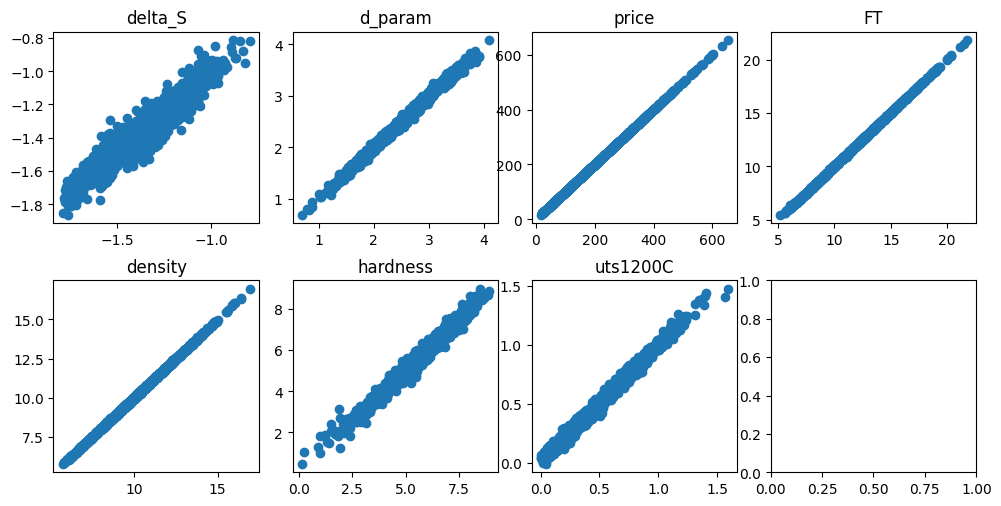

In [5]:
fig,ax = plt.subplots(2,4,figsize = (10,5))
fig.tight_layout(h_pad=2.0, w_pad=-1)
ax = ax.ravel()

print('MSE:')
for i,p in enumerate(props_list):
    y = demo_df.loc[:,p].values
    X_train,X_test, y_train,y_test  = train_test_split(X,y,random_state=42,test_size=0.2,shuffle=True)
    with resources.files('heagan.saved_surrogates').joinpath(f'surrogate_{p}.onnx') as fname:
        sess = onnxruntime.InferenceSession(str(fname))
    input_name = sess.get_inputs()[0].name
    label_name = sess.get_outputs()[0].name
    y_pred = sess.run([label_name], {input_name: X_test.astype(np.float32)})[0]
    prop_name = sess.get_modelmeta().graph_name.removeprefix('surrogate_')
    ax[i].scatter(y_test,y_pred)
    ax[i].set_title(prop_name, fontsize=12)
    print(f'{prop_name:<9}: {round(mean_squared_error(y_pred,y_test), 6)}')